# Mechanical systems
This notebook explores what is called [mechanical–electrical analogies](https://en.wikipedia.org/wiki/Mechanical%E2%80%93electrical_analogies) and is an example of how MNA methods can be used to analized non-circuit problems. In @Akbaba2022, two examples of mechanical systems are analyized. The first is a translational mechanical system and the second is a rotational mechanical system. The code presented here will analyze the equalivent electrical circuits and not cover the derivation of the electrical circuits. 

## Translational mechanical system

![The mechanical and electrical schematic for the mechanical system under consideration is shown. The Figure is from @Akbaba2022, licensed under Creative Commons Attribution-Non Commercial-No Derivatives 4.0 License.](translational-mech-sys-fig-1-2.png){#fig-translational-mech-sys-fig-1-2}

The first example in @Akbaba2022, is a translational mechanical system shown in @fig-translational-mech-sys-fig-1-2. The mechaninical system consists of masses, springs, damping elements and sliding friction. 

The system parameters for mechanical system given in Figure 1 are: 

- Mechanical Load Masses: M1 = 100 kg, M2 = 40 kg, M3 = 80 kg
- Stiffness Elements: K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2
- Viscous Friction elements: B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m
- The applied force: $F(t) = 400sin(4t)e^{-0.1 t}$ is changed to a unit step function, $\frac {1}{s}$.

The equalivent electrical circuit was entered into LTSpice so that a net list could be generated. The circuit has 16 branches and 11 nodes. The capacitor values in @fig-translational-mech-sys have entered as equations. For example, the value for $C_1$ is `{1/500}`, for which LTSpice will calculate a value of 0.002.

![Schematic](translational-mech-sys.png){#fig-translational-mech-sys}

The net list for the circuit is listed below.
```
V1 1 0 PULSE(0 1 1 1e-10 0 20 100 2)
C1 1 2 {1/500}
Ceq 3 4 {1/(500+250)}
C4 4 5 {1/300}
C5 7 8 {1/200}
C6 9 10 {1/180}
R1 2 0 80
R2 5 0 30
R3 3 4 50
R4 7 4 40
R5 8 6 10
R7 11 8 20
R6 11 10 30
L1 1 3 100
L3 3 9 80
L2 6 5 40
```
Transient analysis is somewhat more involved than the other types of circuit analysis, primarily because SymPy's inverse Laplace transform is not very robust and can't handle complicated expressions. The output equation needs to be simplified by writing some code to put the equation into forms that SymPy can deal with. 

Load the following Python modules.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

Load the netlist generated by LTSpice. 
<!--
B = R
K = 1/C
M = L

(B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m)  
(R1 = 80, R2 = 30, R3 = 50, R4 = 40, R5 = 10, R6 = 30, R7 = 20)

(M1 = 100 kg, M2 = 40 kg, M3 = 80 kg)  
(L1 = 100, L2 = 40, L3 = 80)  

1/K = C
(K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2 )  
(C1 = 500, C2 = 250, C33 = 150, C4 = 300, C5 = 200, C6 = 180, Ceq = k1 + k2 )
-->

The element values in the net list have been set to one. In the code cells below, the correct values will be substituted into the network equations. 

In [10]:
net_list = '''
V1 1 0 1
C1 1 2 1
Ceq 3 4 1
C4 4 5 1
C5 7 8 1
C6 9 10 1
R1 2 0 1
R2 5 0 1
R3 3 4 1
R4 7 4 1
R5 8 6 1
R7 11 8 1
R6 11 10 1
L1 1 3 1
L3 3 9 1
L2 6 5 1
'''

Generate and display the network equations.

In [11]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# generate markdown text to display the network equations.
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{L1} + I_{V1} = 0$<br>$- C_{1} s v_{1} + v_{2} \left(C_{1} s + \frac{1}{R_{1}}\right) = 0$<br>$- I_{L1} + I_{L3} + v_{3} \left(Ceq s + \frac{1}{R_{3}}\right) + v_{4} \left(- Ceq s - \frac{1}{R_{3}}\right) = 0$<br>$- C_{4} s v_{5} + v_{3} \left(- Ceq s - \frac{1}{R_{3}}\right) + v_{4} \left(C_{4} s + Ceq s + \frac{1}{R_{4}} + \frac{1}{R_{3}}\right) - \frac{v_{7}}{R_{4}} = 0$<br>$- C_{4} s v_{4} - I_{L2} + v_{5} \left(C_{4} s + \frac{1}{R_{2}}\right) = 0$<br>$I_{L2} + \frac{v_{6}}{R_{5}} - \frac{v_{8}}{R_{5}} = 0$<br>$- C_{5} s v_{8} + v_{7} \left(C_{5} s + \frac{1}{R_{4}}\right) - \frac{v_{4}}{R_{4}} = 0$<br>$- C_{5} s v_{7} + v_{8} \left(C_{5} s + \frac{1}{R_{7}} + \frac{1}{R_{5}}\right) - \frac{v_{11}}{R_{7}} - \frac{v_{6}}{R_{5}} = 0$<br>$- C_{6} s v_{10} + C_{6} s v_{9} - I_{L3} = 0$<br>$- C_{6} s v_{9} + v_{10} \left(C_{6} s + \frac{1}{R_{6}}\right) - \frac{v_{11}}{R_{6}} = 0$<br>$v_{11} \cdot \left(\frac{1}{R_{7}} + \frac{1}{R_{6}}\right) - \frac{v_{8}}{R_{7}} - \frac{v_{10}}{R_{6}} = 0$<br>$v_{1} = V_{1}$<br>$- I_{L1} L_{1} s + v_{1} - v_{3} = 0$<br>$- I_{L3} L_{3} s + v_{3} - v_{9} = 0$<br>$- I_{L2} L_{2} s - v_{5} + v_{6} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand.

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [12]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

### Symbolic solution
Since the circuit is large, a symbolic solution takes a long time, so code is commented out.

In [13]:
#U_sym = solve(NE_sym,X)

Display the symbolic solution

In [14]:
#temp = ''
#for i in U_sym.keys():
#    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

#Markdown(temp)

### Numerical solution
Built a dictionary of element values.

In [15]:
t = symbols('t',positive=True)  # t > 0

In [16]:
element_values = SymMNA.get_part_values(network_df)
element_values

R's

(B1 = 80 N.s/m, B2 = 30 N.s/m, B3 = 50 N.s/m, B4 = 40 N.s/m, B5 = 10 N.s/m, B6 = 30 N.s/m, B7 = 20 N.s/m)  

(R1 = 80, R2 = 30, R3 = 50, R4 = 40, R5 = 10, R6 = 30, R7 = 20)

In [17]:
B1 = 80
B2 = 30
B3 = 50
B4 = 40
B5 = 10
B6 = 30
B7 = 20
element_values[R1] = B1
element_values[R2] = B2
element_values[R3] = B3
element_values[R4] = B4
element_values[R5] = B5
element_values[R6] = B6
element_values[R7] = B7

L's  

(M1 = 100 kg, M2 = 40 kg, M3 = 80 kg)  

(L1 = 100, L2 = 40, L3 = 80) 

In [18]:
M1 = 100
M2 = 40
M3 = 80
element_values[L1] = M1
element_values[L2] = M2
element_values[L3] = M3

Using C = 1/K

1/K = C

(K1 = 500 N/m, K2 = 250 N/m, K3 = 150 N/m, K4 = 300 N/m, K5 = 200 N/m, K6 = 180 N/m, Keq = k1 + k2 )  

(C1 = 500, C2 = 250, C3 = 150, C4 = 300, C5 = 200, C6 = 180, Ceq = k1 + k2 )

In [19]:
K1 = 500
K2 = 250
K3 = 150
K4 = 300
K5 = 200
K6 = 180
Keq = K1 + K2 

element_values[C1] = 1/K1
element_values[C4] = 1/K4
element_values[C5] = 1/K5
element_values[C6] = 1/K6
element_values[Ceq] = 1/Keq

In [20]:
element_values

### Mechanical Analogies
@Akbaba2022 stated that the inductor current is equalivent to the velocity of the mass in a translational mechanical system. Displacement is equalivent to the charge in a capacitor. In the mechanical system shown in @fig-translational-mech-sys-fig-1-2, we will look at the velocity of mass, M3, and its displacement in response to a step function. In the example, @Akbaba2022, uses a dampled sinusoidal function as the driving force, here I'm going to drive the system with a step function. In the cell below, the dampled sinusoidal function is has been commented out and V1 is a unit step function.  

In [21]:
#element_values[V1] = laplace_transform(400*exp(-0.1*t)*sin(4*t), t, s)[0] # driving function in example
element_values[V1] = laplace_transform(1*Heaviside(t), t, s)[0] # step function as a test
NE = NE_sym.subs(element_values)
NE

⎡                                 I_L1 + I_V1 + 0.002⋅s⋅v₁ - 0.002⋅s⋅v₂       
⎢                                                                             
⎢                                   -0.002⋅s⋅v₁ + v₂⋅(0.002⋅s + 1/80)         
⎢                                                                             
⎢         -I_L1 + I_L3 + v₃⋅(0.00133333333333333⋅s + 1/50) + v₄⋅(-0.0013333333
⎢                                                                             
⎢                                                                             
⎢-0.00333333333333333⋅s⋅v₅ + v₃⋅(-0.00133333333333333⋅s - 1/50) + v₄⋅(0.004666
⎢                                                                             
⎢                                                                             
⎢                  -I_L2 - 0.00333333333333333⋅s⋅v₄ + v₅⋅(0.00333333333333333⋅
⎢                                                                             
⎢                                                   

In [22]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = \frac{1}{s}$<br>$v_{2} = \frac{4.0}{4.0 s + 25.0}$<br>$v_{3} = \frac{96.0 s^{6} + 5028.0 s^{5} + 28443.0 s^{4} + 125715.0 s^{3} + 226350.0 s^{2} + 240300.0 s + 162000.0}{320.0 s^{8} + 5656.0 s^{7} + 25238.0 s^{6} + 124143.0 s^{5} + 250215.0 s^{4} + 451350.0 s^{3} + 240300.0 s^{2} + 162000.0 s}$<br>$v_{4} = \frac{96.0 s^{6} + 2628.0 s^{5} + 22743.0 s^{4} + 82140.0 s^{3} + 199350.0 s^{2} + 172800.0 s + 162000.0}{320.0 s^{8} + 5656.0 s^{7} + 25238.0 s^{6} + 124143.0 s^{5} + 250215.0 s^{4} + 451350.0 s^{3} + 240300.0 s^{2} + 162000.0 s}$<br>$v_{5} = \frac{96.0 s^{5} + 1668.0 s^{4} + 6063.0 s^{3} + 28710.0 s^{2} + 37350.0 s + 67500.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>$v_{6} = \frac{96.0 s^{5} + 2628.0 s^{4} + 22743.0 s^{3} + 64470.0 s^{2} + 105750.0 s + 67500.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>$v_{7} = \frac{96.0 s^{6} + 2628.0 s^{5} + 22983.0 s^{4} + 67440.0 s^{3} + 188190.0 s^{2} + 140400.0 s + 162000.0}{320.0 s^{8} + 5656.0 s^{7} + 25238.0 s^{6} + 124143.0 s^{5} + 250215.0 s^{4} + 451350.0 s^{3} + 240300.0 s^{2} + 162000.0 s}$<br>$v_{8} = \frac{96.0 s^{5} + 2628.0 s^{4} + 22983.0 s^{3} + 68640.0 s^{2} + 114690.0 s + 84600.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>$v_{9} = \frac{96.0 s^{6} + 2628.0 s^{5} + 24483.0 s^{4} + 76515.0 s^{3} + 154350.0 s^{2} + 240300.0 s + 162000.0}{320.0 s^{8} + 5656.0 s^{7} + 25238.0 s^{6} + 124143.0 s^{5} + 250215.0 s^{4} + 451350.0 s^{3} + 240300.0 s^{2} + 162000.0 s}$<br>$v_{10} = \frac{96.0 s^{5} + 2628.0 s^{4} + 24483.0 s^{3} + 71115.0 s^{2} + 145440.0 s + 129600.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>$v_{11} = \frac{96.0 s^{5} + 2628.0 s^{4} + 23583.0 s^{3} + 69630.0 s^{2} + 126990.0 s + 102600.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>$I_{V1} = \frac{- 320.0 s^{7} - 5912.0 s^{6} - 31286.0 s^{5} - 168111.0 s^{4} - 427825.0 s^{3} - 1029450.0 s^{2} - 1042800.0 s - 1287000.0}{25600.0 s^{8} + 612480.0 s^{7} + 4847040.0 s^{6} + 22550440.0 s^{5} + 82088700.0 s^{4} + 161215500.0 s^{3} + 244899000.0 s^{2} + 133110000.0 s + 81000000.0}$<br>$I_{L1} = \frac{32.0 s^{5} + 556.0 s^{4} + 2021.0 s^{3} + 9570.0 s^{2} + 12450.0 s + 22500.0}{3200.0 s^{7} + 56560.0 s^{6} + 252380.0 s^{5} + 1241430.0 s^{4} + 2502150.0 s^{3} + 4513500.0 s^{2} + 2403000.0 s + 1620000.0}$<br>$I_{L3} = \frac{60.0 s^{3} + 99.0 s^{2} + 1230.0 s + 1800.0}{640.0 s^{7} + 11312.0 s^{6} + 50476.0 s^{5} + 248286.0 s^{4} + 500430.0 s^{3} + 902700.0 s^{2} + 480600.0 s + 324000.0}$<br>$I_{L2} = \frac{24.0 s^{3} + 417.0 s^{2} + 894.0 s + 1710.0}{320.0 s^{7} + 5656.0 s^{6} + 25238.0 s^{5} + 124143.0 s^{4} + 250215.0 s^{3} + 451350.0 s^{2} + 240300.0 s + 162000.0}$<br>

### Velocity of $M_3$
The current in L3 is equalivent to the velocity of $M_3$ and the following cells compute the current in the inductor. The current through L3 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

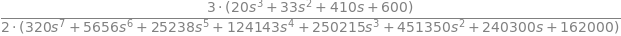

In [23]:
L3_current_s = U[I_L3].nsimplify().simplify().expand().together()
L3_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [24]:
#L3_current = inverse_laplace_transform(L3_current_s, s, t)
#L3_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [25]:
n, d = fraction(L3_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $60 s^{3} + 99 s^{2} + 1230 s + 1800$<br>denominator: $640 s^{7} + 11312 s^{6} + 50476 s^{5} + 248286 s^{4} + 500430 s^{3} + 902700 s^{2} + 480600 s + 324000$

Each of the numerator terms can be put over the common denominator.

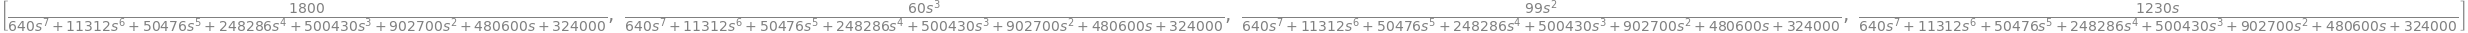

In [26]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- the SciPy function [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) is used to get the residues and poles of the partial-fraction expansion
- build the partial expansion terms and find the inverse Laplace of each term and save

Returns:

- r: Residues corresponding to the poles. For repeated poles, the residues are ordered to correspond to ascending by power fractions.
- p: Poles ordered by magnitude in ascending order.
- k: Coefficients of the direct polynomial term.

When computing the inverse Laplace transform, the Coefficients (k) are ignored since these transform to a Dirac delta function, $\delta (t)$ and don't need to be plotted.

In [27]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [28]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

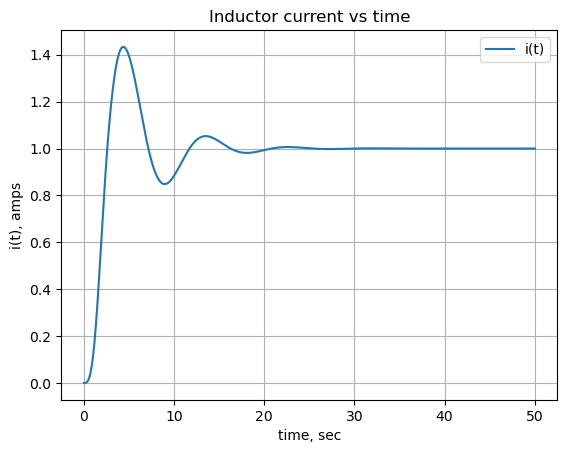

In [63]:
plt.title('Inductor current vs time')

plt.plot(x, np.real(V_node2),label='i(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('i(t), amps')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Displacement of $M_3$
The displacement of $M_3$ is equalavent to the charge on C6 which is proportional to the voltage difference between nodes 9 and 10. 

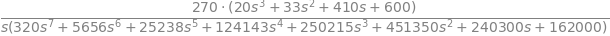

In [30]:
C6_voltage_s = (U[v9] - U[v10]).nsimplify().simplify().expand().together()
C6_voltage_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [31]:
#C6_voltage = inverse_laplace_transform(C6_voltage_s, s, t)
#C6_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [32]:
n, d = fraction(C6_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $5400 s^{3} + 8910 s^{2} + 110700 s + 162000$<br>denominator: $s \left(320 s^{7} + 5656 s^{6} + 25238 s^{5} + 124143 s^{4} + 250215 s^{3} + 451350 s^{2} + 240300 s + 162000\right)$

Each of the numerator terms can be put over the common denominator.

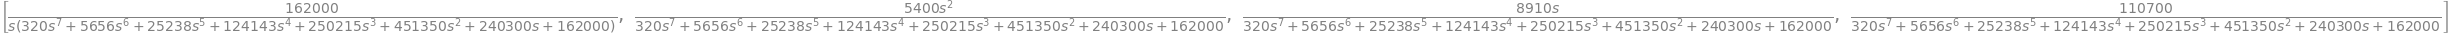

In [33]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

In [34]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [35]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node2 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node2 += lambdify(t, p)(x)

Plot the final combined result.

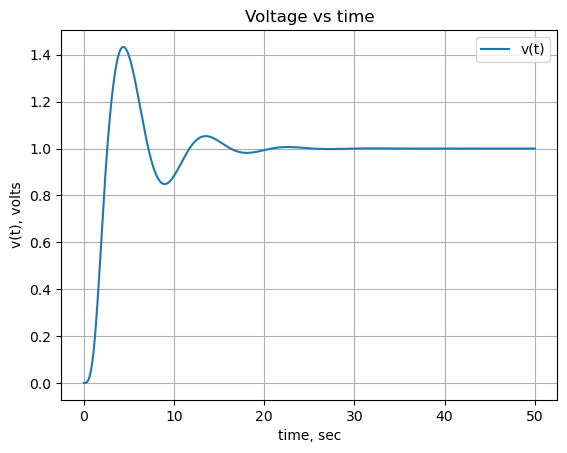

In [64]:
plt.title('Voltage vs time')

plt.plot(x, np.real(V_node2),label='v(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Rotational mechanical system

![The mechanical and electrical schematic for the mechanical system under consideration is shown. The Figure is from @Akbaba2022, licensed under Creative Commons Attribution-Non Commercial-No Derivatives 4.0 License.](rotational-mech-sys-fig-10-11.png){#fig-rotational-mech-sys-fig-10-11}

The second example in @Akbaba2022, is a rotational mechanical system shown in @fig-rotational-mech-sys-fig-10-11. The conversion of the mechanical parameters: 

- the moment of inertia
- rotational stiffness or rotational spring element
- rotational viscous friction or rotational damper element

to electrical elements in the equalivent circuit is not include in my calculations. All the electrical elment values are set to one. The reason for this is the converseion is not straight forward and somewhat outside the scope of circuit analysis. 

The circuit was drawn in LTSpice so that the netlist could be obtained.

![Schematic](rotational-mech-sys.png){#fig-rotational-mech-sys}

Load the netlist. The value of $V_L$ is set to zero.

In [37]:
net_list = '''
Va 1 0 1
VL 14 0 0
La 1 2 1
Lm 5 6 1
L1 7 8 1
L2 9 10 1
L5 0 10 1
L6 11 0 1
L3 11 12 1
L4 13 14 1
Ra 3 0 1
Rmb 5 4 1
R1 7 6 1
R4 13 12 1
C1 9 0 1
C2 12 0 1
Ha 2 3 V1 1
Hm 4 0 Va 1
V1 9 8 0
K1 L5 L6 0.5
'''

Generate and display the network equations.

In [38]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# generate markdown text to display the network equations.
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{La} + I_{Va} = 0$<br>$I_{Ha} - I_{La} = 0$<br>$- I_{Ha} + \frac{v_{3}}{Ra} = 0$<br>$I_{Hm} + \frac{v_{4}}{Rmb} - \frac{v_{5}}{Rmb} = 0$<br>$I_{Lm} - \frac{v_{4}}{Rmb} + \frac{v_{5}}{Rmb} = 0$<br>$- I_{Lm} + \frac{v_{6}}{R_{1}} - \frac{v_{7}}{R_{1}} = 0$<br>$I_{L1} - \frac{v_{6}}{R_{1}} + \frac{v_{7}}{R_{1}} = 0$<br>$- I_{L1} - I_{V1} = 0$<br>$C_{1} s v_{9} + I_{L2} + I_{V1} = 0$<br>$- I_{L2} - I_{L5} = 0$<br>$I_{L3} + I_{L6} = 0$<br>$- I_{L3} + v_{12} \left(C_{2} s + \frac{1}{R_{4}}\right) - \frac{v_{13}}{R_{4}} = 0$<br>$I_{L4} - \frac{v_{12}}{R_{4}} + \frac{v_{13}}{R_{4}} = 0$<br>$- I_{L4} + I_{Vl} = 0$<br>$v_{1} = Va$<br>$v_{14} = Vl$<br>$- v_{8} + v_{9} = V_{1}$<br>$- I_{La} La s + v_{1} - v_{2} = 0$<br>$- I_{Lm} Lm s + v_{5} - v_{6} = 0$<br>$- I_{L1} L_{1} s + v_{7} - v_{8} = 0$<br>$- I_{L2} L_{2} s - v_{10} + v_{9} = 0$<br>$- I_{L5} L_{5} s - I_{L6} M_{1} s - v_{10} = 0$<br>$- I_{L5} M_{1} s - I_{L6} L_{6} s + v_{11} = 0$<br>$- I_{L3} L_{3} s + v_{11} - v_{12} = 0$<br>$- I_{L4} L_{4} s + v_{13} - v_{14} = 0$<br>$- I_{V1} ha + v_{2} - v_{3} = 0$<br>$- I_{Va} hm + v_{4} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand.

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [39]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Since the circuit is large, a symbolic solution takes a long time, so code is commented out.

In [40]:
#U_sym = solve(NE_sym,X)

Display the symbolic solution

In [41]:
#temp = ''
#for i in U_sym.keys():
#    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

#Markdown(temp)

Built a dictionary of element values.

In [42]:
element_values = SymMNA.get_part_values(network_df)
element_values

The mutual inductance between L1 and L2 is calculated from the coupling coeeficient.

$M = k\sqrt{L_1L_2}$

In [43]:
K1 = symbols('K1')

# calculate the coupling constant from the mutual inductance
element_values[M1] = element_values[K1]*np.sqrt(element_values[L5] * element_values[L6])
print('mutual inductance, M1 = {:.9f}'.format(element_values[M1]))

mutual inductance, M1 = 0.500000000


Re-define the symbol $t$ for time and define $V_a$ to be a voltage step. 

In [44]:
t = symbols('t',positive=True)  # t > 0

In [45]:
element_values[Va] = laplace_transform(1*Heaviside(t), t, s)[0]
NE = NE_sym.subs(element_values)
NE

                                    ⎡0⎤
⎡          I_La + I_Va          ⎤   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢          I_Ha - I_La          ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢        -I_Ha + 1.0⋅v₃         ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢      I_Hm + 1.0⋅v₄ - v₅       ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢      I_Lm - v₄ + 1.0⋅v₅       ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢      -I_Lm + 1.0⋅v₆ - v₇      ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢      I_L1 - v₆ + 1.0⋅v₇       ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢         -I_L1 - I_V1          ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢    I_L2 + I_V1 + 1.0⋅s⋅v₉     ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢         -I_L2 - I_L5          ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢          I_L3 + I_L6          ⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥
⎢-I_L3 + v₁₂⋅(1.0⋅s + 1.0) - v₁₃⎥   ⎢ ⎥
⎢                               ⎥   ⎢0⎥


In [46]:
U = solve(NE,X)

temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = \frac{1}{s}$<br>$v_{2} = \frac{30.0 s^{6} + 75.0 s^{5} + 122.0 s^{4} + 140.0 s^{3} + 95.0 s^{2} + 52.0 s + 12.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{3} = \frac{30.0 s^{6} + 60.0 s^{5} + 107.0 s^{4} + 109.0 s^{3} + 79.0 s^{2} + 40.0 s + 8.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{4} = \frac{- 30.0 s^{6} - 60.0 s^{5} - 107.0 s^{4} - 109.0 s^{3} - 79.0 s^{2} - 40.0 s - 8.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{5} = \frac{- 30.0 s^{6} - 45.0 s^{5} - 92.0 s^{4} - 78.0 s^{3} - 63.0 s^{2} - 28.0 s - 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{6} = \frac{- 15.0 s^{6} - 30.0 s^{5} - 61.0 s^{4} - 62.0 s^{3} - 51.0 s^{2} - 24.0 s - 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$v_{7} = \frac{- 15.0 s^{5} - 15.0 s^{4} - 46.0 s^{3} - 31.0 s^{2} - 35.0 s - 12.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{8} = \frac{- 15.0 s^{3} - 15.0 s^{2} - 23.0 s - 8.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{9} = \frac{- 15.0 s^{3} - 15.0 s^{2} - 23.0 s - 8.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{10} = \frac{- 7.0 s^{3} - 7.0 s^{2} - 11.0 s - 4.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{11} = \frac{2.0 s^{3} + 2.0 s^{2} + 4.0 s + 2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{12} = \frac{2.0 s + 2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{13} = \frac{2.0 s}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$v_{14} = 0.0$<br>$I_{Va} = \frac{- 30.0 s^{6} - 60.0 s^{5} - 107.0 s^{4} - 109.0 s^{3} - 79.0 s^{2} - 40.0 s - 8.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Vl} = \frac{2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{V1} = \frac{15.0 s^{5} + 15.0 s^{4} + 31.0 s^{3} + 16.0 s^{2} + 12.0 s + 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{La} = \frac{30.0 s^{6} + 60.0 s^{5} + 107.0 s^{4} + 109.0 s^{3} + 79.0 s^{2} + 40.0 s + 8.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Lm} = \frac{- 15.0 s^{5} - 15.0 s^{4} - 31.0 s^{3} - 16.0 s^{2} - 12.0 s - 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L1} = \frac{- 15.0 s^{5} - 15.0 s^{4} - 31.0 s^{3} - 16.0 s^{2} - 12.0 s - 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L2} = \frac{- 8.0 s^{3} - 8.0 s^{2} - 12.0 s - 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L5} = \frac{8.0 s^{3} + 8.0 s^{2} + 12.0 s + 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{L6} = \frac{- 2.0 s^{2} - 2.0 s - 2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{L3} = \frac{2.0 s^{2} + 2.0 s + 2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{L4} = \frac{2.0}{30.0 s^{7} + 90.0 s^{6} + 182.0 s^{5} + 231.0 s^{4} + 219.0 s^{3} + 135.0 s^{2} + 60.0 s + 12.0}$<br>$I_{Ha} = \frac{30.0 s^{6} + 60.0 s^{5} + 107.0 s^{4} + 109.0 s^{3} + 79.0 s^{2} + 40.0 s + 8.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>$I_{Hm} = \frac{15.0 s^{5} + 15.0 s^{4} + 31.0 s^{3} + 16.0 s^{2} + 12.0 s + 4.0}{30.0 s^{8} + 90.0 s^{7} + 182.0 s^{6} + 231.0 s^{5} + 219.0 s^{4} + 135.0 s^{3} + 60.0 s^{2} + 12.0 s}$<br>

### Va current
The current from Va is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

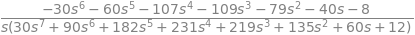

In [47]:
Va_current_s = U[I_Va].nsimplify().simplify().expand().together()
Va_current_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [48]:
#Va_current = inverse_laplace_transform(Va_current_s, s, t)
#Va_current

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [49]:
n, d = fraction(Va_current_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $- 30 s^{6} - 60 s^{5} - 107 s^{4} - 109 s^{3} - 79 s^{2} - 40 s - 8$<br>denominator: $s \left(30 s^{7} + 90 s^{6} + 182 s^{5} + 231 s^{4} + 219 s^{3} + 135 s^{2} + 60 s + 12\right)$

Each of the numerator terms can be put over the common denominator.

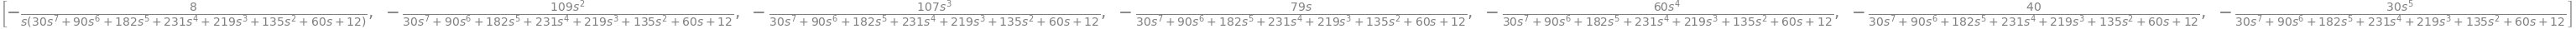

In [50]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

In [51]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [52]:
x = np.linspace(0, 50, 2000, endpoint=True)
Va_current = np.zeros(len(x),dtype = complex)
for p in N:
    Va_current += lambdify(t, p)(x)

Plot the final combined result.

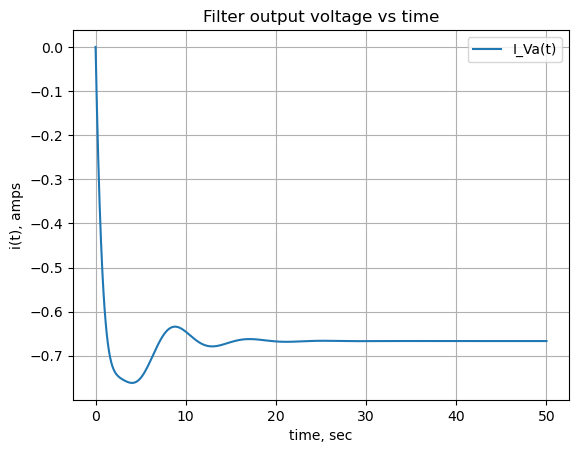

In [53]:
plt.title('Current vs time')

plt.plot(x, np.real(Va_current),label='I_Va(t)')

plt.ylabel('i(t), amps')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

### Node 12 voltage
The voltage at node 12 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

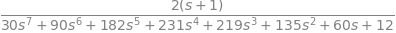

In [54]:
node12_voltage_s = U[v12].nsimplify().simplify().expand().together()
node12_voltage_s

The inverse Laplace was taking too long, so the lines of code were commented out

In [55]:
#node12_voltage = inverse_laplace_transform(node12_voltage_s, s, t)
#node12_voltage

Using NumPy to obtain the partial fraction expansion, convert back to the s domain and then take the inverse Laplace transform on each term.

Extract the numerator and denominator and display.

In [56]:
n, d = fraction(node12_voltage_s)
n = n.expand()
Markdown('numerator: ${:s}$<br>denominator: ${:s}$'.format(latex(n),latex(d)))

numerator: $2 s + 2$<br>denominator: $30 s^{7} + 90 s^{6} + 182 s^{5} + 231 s^{4} + 219 s^{3} + 135 s^{2} + 60 s + 12$

Each of the numerator terms can be put over the common denominator.

In [57]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

In [58]:
N = []

for p1 in terms:

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(p1)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')

    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i]))
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [59]:
x = np.linspace(0, 50, 2000, endpoint=True)
V_node12 = np.zeros(len(x),dtype = complex)
for p in N:
    V_node12 += lambdify(t, p)(x)

Plot the final combined result.

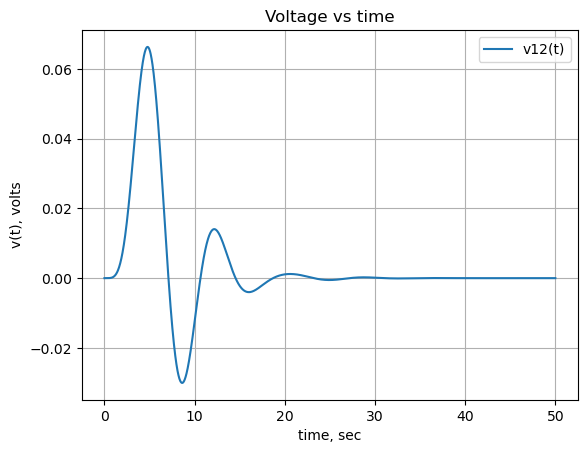

In [65]:
plt.title('Voltage vs time')

plt.plot(x, np.real(V_node12),label='v12(t)')
#plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Summary
test